Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1QR37D_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1QR37D_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 137s 726ms/step - accuracy: 0.6224 - loss: 0.6400 - val_accuracy: 0.7545 - val_loss: 0.5109
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 568ms/step - accuracy: 0.7744 - loss: 0.4907 - val_accuracy: 0.8138 - val_loss: 0.4265
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - accuracy: 0.8033 - loss: 0.4466 - val_accuracy: 0.8317 - val_loss: 0.3954
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - accuracy: 0.8229 - loss: 0.4043 - val_accuracy: 0.8323 - val_loss: 0.3970
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 569ms/step - accuracy: 0.8409 - loss: 0.3706 - val_accuracy: 0.8687 - val_loss: 0.3090
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 78s 534ms/step - accuracy: 0.8663 - loss: 0.3148 - val_accuracy: 0.8749 - val_loss: 0.3009
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 530ms/step - accuracy: 0.8822 

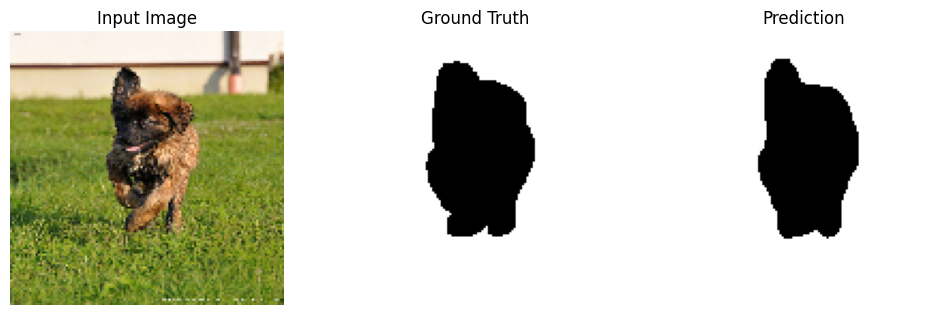

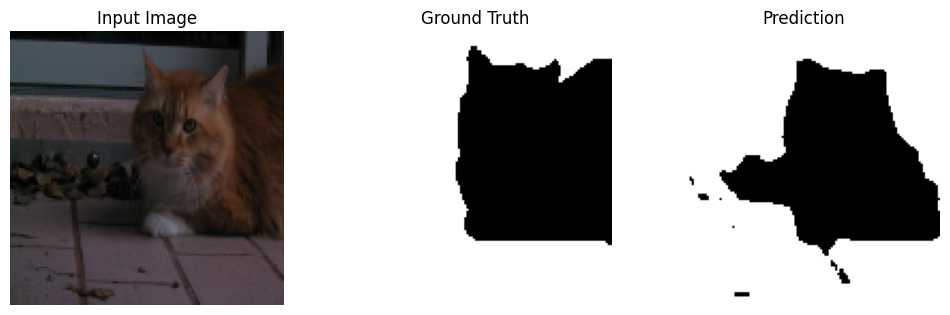

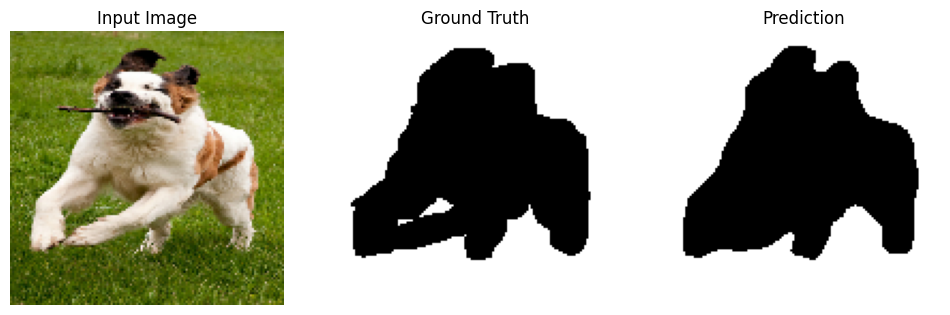

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10

# Load Oxford-IIIT Pet Dataset with segmentation masks
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
train_ds = dataset['train']
test_ds = dataset['test']

# Preprocessing function
def preprocess(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(example['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32)
    mask = tf.where(mask == 2, 1.0, 0.0)  # Convert to binary: pet (1) vs background (0)

    return image, mask

# Apply preprocessing and batching
train_batches = (train_ds.map(preprocess)
                 .cache()
                 .shuffle(1000)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

test_batches = (test_ds.map(preprocess)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

# U-Net model
def unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    def conv_block(x, filters):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = tf.keras.layers.MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return tf.keras.Model(inputs, outputs)

# Compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_batches, validation_data=test_batches, epochs=EPOCHS)

# Evaluate
model.evaluate(test_batches)

# Visualize predictions
def display_sample_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images[:num])
        for i in range(num):
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
            plt.title("Prediction")
            plt.axis('off')
            plt.show()

display_sample_predictions(test_batches, model)


In [1]:
# ---------------------------------------------
# STEP 1: INSTALL DEPENDENCIES
# ---------------------------------------------
!pip install -q kaggle tensorflow opencv-python-headless scipy scikit-learn

# ---------------------------------------------
# STEP 2: UPLOAD kaggle.json FOR AUTH
# ---------------------------------------------
from google.colab import files
files.upload()  # Upload kaggle.json manually here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ---------------------------------------------
# STEP 3: DOWNLOAD AND UNZIP DATASET
# ---------------------------------------------
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map
!unzip -q shanghaitech-with-people-density-map.zip -d /content/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech-with-people-density-map
License(s): unknown
100% 4.77G/4.79G [01:23<00:00, 215MB/s]
100% 4.79G/4.79G [01:23<00:00, 61.3MB/s]


In [8]:
import os
import cv2
import h5py
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from glob import glob
import scipy.io as sio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

# Set constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 4
EPOCHS = 10
BASE_DIR = "/content/ShanghaiTech/part_A/train_data"

# STEP 1: DATA PREPARATION

def load_data(base_path, is_train=True):
    img_dir = os.path.join(base_path, "images")
    gt_dir = os.path.join(base_path, "ground-truth")

    images = []
    density_maps = []

    for fname in os.listdir(img_dir):
        if not fname.endswith(".jpg"):
            continue
        img_path = os.path.join(img_dir, fname)
        gt_path = os.path.join(gt_dir, "GT_" + fname.replace(".jpg", ".mat"))

        # Read and resize image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img.astype(np.float32) / 255.0

        # Generate density map
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        density_map = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
        h, w, _ = cv2.imread(img_path).shape
        x_scale = IMG_WIDTH / w
        y_scale = IMG_HEIGHT / h

        for point in points:
            x = min(int(point[0] * x_scale), IMG_WIDTH - 1)
            y = min(int(point[1] * y_scale), IMG_HEIGHT - 1)
            density_map[y, x] += 1.0

        density_map = cv2.GaussianBlur(density_map, (15, 15), 0)
        density_map = density_map[..., np.newaxis]

        images.append(img)
        density_maps.append(density_map)

    return np.array(images), np.array(density_maps)

X, Y = load_data(BASE_DIR)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# STEP 2: BUILD U-NET MODEL

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = layers.Concatenate()([x, skip])
        return conv_block(x, filters)

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bottleneck = conv_block(p4, 1024)

    d1 = decoder_block(bottleneck, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = layers.Conv2D(1, 1, activation="linear")(d4)

    return Model(inputs, outputs)

unet = build_unet()
unet.compile(optimizer=Adam(1e-4), loss="mse")

# STEP 3: TRAIN U-NET

unet.fit(X_train, Y_train,
         validation_data=(X_val, Y_val),
         batch_size=BATCH_SIZE,
         epochs=EPOCHS)

# STEP 4: BUILD MCNN MODEL

def build_mcnn_model():
    input_layer = Input(shape=(224, 224, 3))

    # Column 1
    col1 = Conv2D(16, (9, 9), padding='same', activation='relu')(input_layer)
    col1 = MaxPooling2D(pool_size=(2, 2))(col1)
    col1 = Conv2D(32, (7, 7), padding='same', activation='relu')(col1)
    col1 = MaxPooling2D(pool_size=(2, 2))(col1)

    # Column 2
    col2 = Conv2D(20, (7, 7), padding='same', activation='relu')(input_layer)
    col2 = MaxPooling2D(pool_size=(2, 2))(col2)
    col2 = Conv2D(40, (5, 5), padding='same', activation='relu')(col2)
    col2 = MaxPooling2D(pool_size=(2, 2))(col2)

    # Column 3
    col3 = Conv2D(24, (5, 5), padding='same', activation='relu')(input_layer)
    col3 = MaxPooling2D(pool_size=(2, 2))(col3)
    col3 = Conv2D(48, (3, 3), padding='same', activation='relu')(col3)
    col3 = MaxPooling2D(pool_size=(2, 2))(col3)

    merged = Concatenate()([col1, col2, col3])
    output = Conv2D(1, (1, 1), padding='same', activation='linear')(merged)

    # ⬆️ Upsample to match input image resolution
    output = UpSampling2D(size=(4, 4), interpolation='bilinear')(output)

    model = Model(inputs=input_layer, outputs=output)
    return model


mcnn = build_mcnn_model()
mcnn.compile(optimizer=Adam(1e-4), loss="mse")


# STEP 5: TRAIN MCNN

mcnn.fit(X_train, Y_train,
         validation_data=(X_val, Y_val),
         batch_size=BATCH_SIZE,
         epochs=EPOCHS)


# STEP 6: EVALUATE AND COMPARE

def evaluate_model(model, X, Y, name):
    preds = model.predict(X)
    gt_count = np.sum(Y, axis=(1, 2, 3))
    pred_count = np.sum(preds, axis=(1, 2, 3))
    mae = np.mean(np.abs(gt_count - pred_count))
    rmse = np.sqrt(np.mean((gt_count - pred_count) ** 2))
    print(f"{name} MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print("\n--- Evaluation Results ---")
evaluate_model(unet, X_val, Y_val, "U-Net")
evaluate_model(mcnn, X_val, Y_val, "MCNN")



Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 244ms/step - loss: 0.0011 - val_loss: 8.2555e-04
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 4.8355e-04 - val_loss: 7.3892e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 6.3130e-04 - val_loss: 7.1865e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 7.5334e-04 - val_loss: 8.5082e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 4.9629e-04 - val_loss: 7.4073e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 5.2036e-04 - val_loss: 7.6471e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - loss: 4.2751e-04 - val_loss: 6.4260e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - loss: 4.9684e-04 - val_loss: 5.8021e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - loss: 5.8005e-04 - val_loss: 5.8343e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 4.4730e-04 - val_loss: 7.9500e-04
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - 

🔍 U-Net Predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


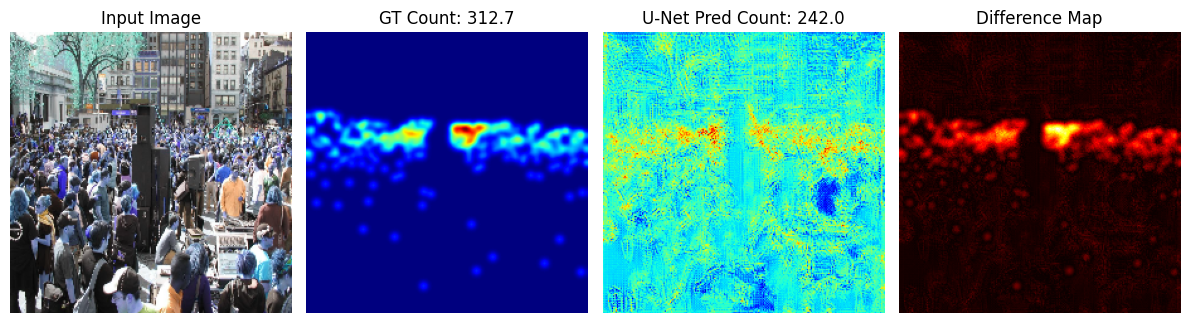

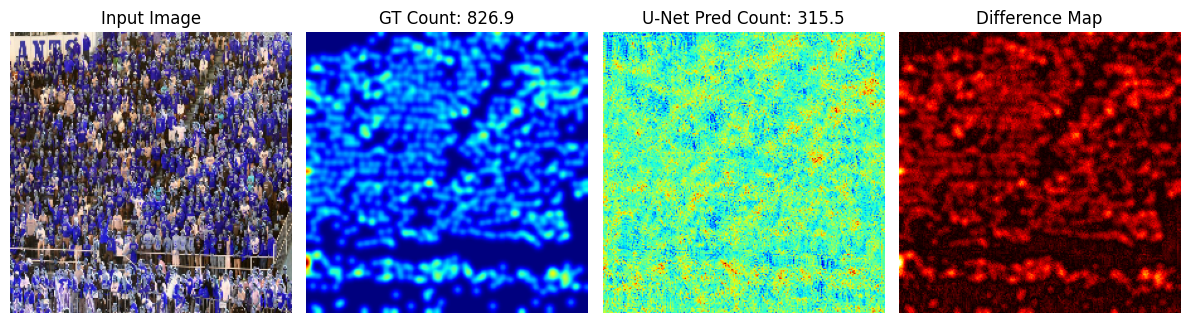

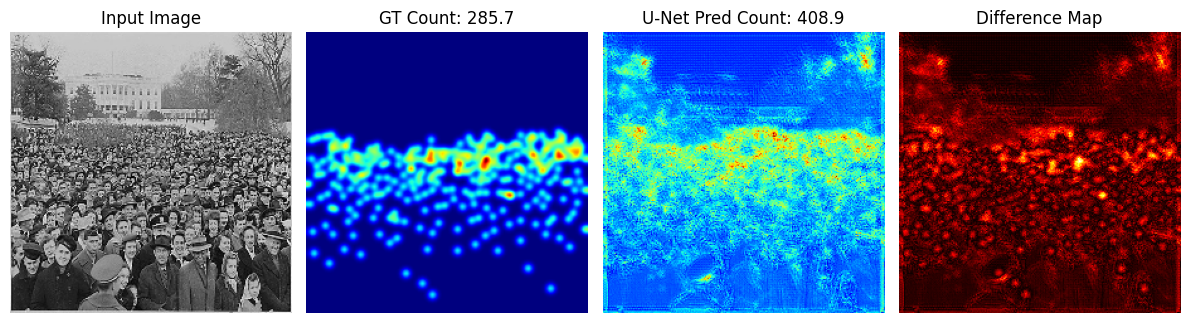

🔍 MCNN Predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


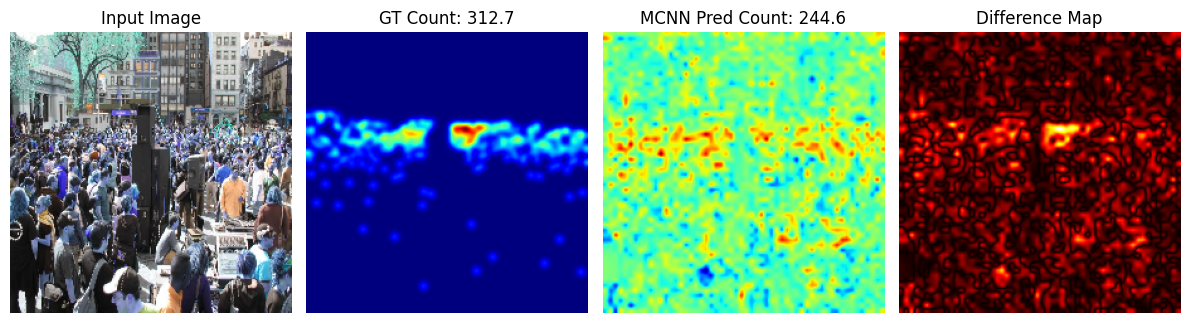

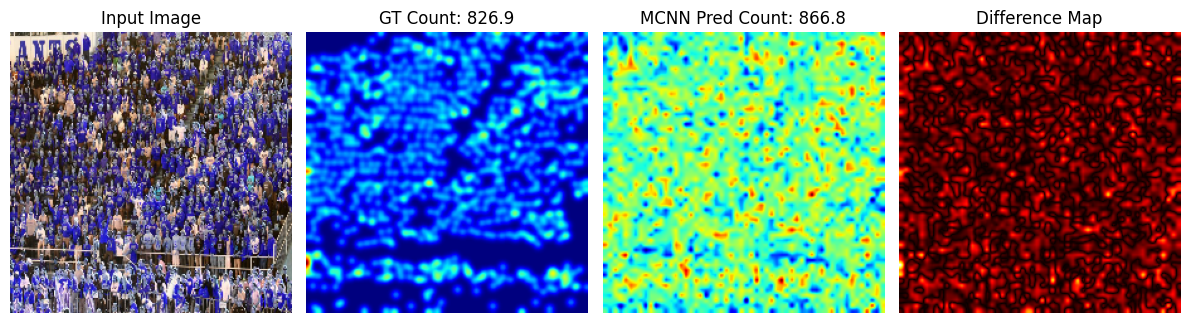

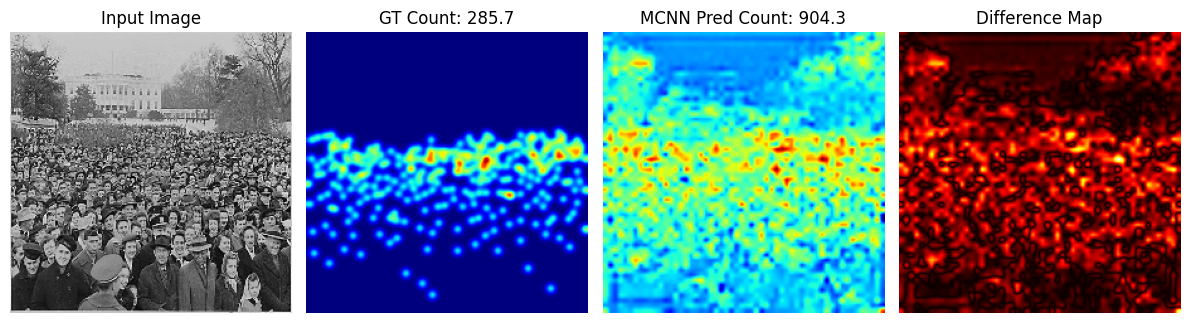

In [9]:
# ---------------------------------------------
# STEP 7: VISUALIZE INPUT, GROUND TRUTH, AND PREDICTIONS
# ---------------------------------------------
def plot_predictions(model, X, Y, model_name, num=5):
    preds = model.predict(X[:num])

    for i in range(num):
        plt.figure(figsize=(12, 4))

        # Input image
        plt.subplot(1, 4, 1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth Density
        plt.subplot(1, 4, 2)
        plt.imshow(Y[i].squeeze(), cmap='jet')
        plt.title(f"GT Count: {np.sum(Y[i]):.1f}")
        plt.axis("off")

        # Predicted Density
        plt.subplot(1, 4, 3)
        plt.imshow(preds[i].squeeze(), cmap='jet')
        plt.title(f"{model_name} Pred Count: {np.sum(preds[i]):.1f}")
        plt.axis("off")

        # Density Difference
        plt.subplot(1, 4, 4)
        diff = np.abs(Y[i].squeeze() - preds[i].squeeze())
        plt.imshow(diff, cmap='hot')
        plt.title("Difference Map")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Visualize predictions for both models
print("🔍 U-Net Predictions")
plot_predictions(unet, X_val, Y_val, "U-Net", num=3)

print("🔍 MCNN Predictions")
plot_predictions(mcnn, X_val, Y_val, "MCNN", num=3)
